In [1]:
import sys
import pandas as pd
import glob
import networkx as nx
import matplotlib.pyplot as plt
import os

In [2]:
def read_network_fibs_and_topo(network_path):
    """
    Read txt files generated by config2specs
    """
    # Read FIB
    router_fibs = {}
    for f in glob.glob(f"{network_path}/fibs/*.txt"):
        print(f)
        with open(f, 'r') as fp:
          content = fp.read()
        # df = pd.DataFrame({'prefix': [], 'if': [], 'type': []})
    
        last_router = None
        for l in content.splitlines():
          if l.startswith('# '):
            last_router = l.split('# ')[1][7:]
            router_fibs[last_router] = []
          elif not l.startswith('#'):
            router_fibs[last_router].append(l)
            # df.loc[len(df.index)] = [l.split(';')[0], l.split(';')[1], l.split(';')[2]]
    # Read Topology and construct networkx Graph
    # topos = []
    topos_map = {}
    with open(f"{network_path}/topology.txt", 'r') as fp:
        content = fp.read()
    for l in content.splitlines():
        d = l.split(', ')
        # topos.append(((d[0].split(":")[0][1:], d[0].split(":")[1]), (d[1].split(":")[0], d[1].split(":")[1][:-1])))
        #G.add_edge(d[0].split(":")[0][1:], d[1].split(":")[0])
        topos_map[(d[0].split(":")[0][1:], d[0].split(":")[1])] = (d[1].split(":")[0], d[1].split(":")[1][:-1])

    return router_fibs, topos_map

In [3]:
def find_important_edges(router_fibs, topos_map, PREFIX_TO_INVESTIGATE):
    # Find the directed edges for that PREFIX_TO_INVESTIGATE
    important_edges = []
    
    for r in router_fibs:
        fibs = router_fibs[r]
        for fib in fibs:
            pfx = fib.split(';')[0]
            typ = fib.split(';')[2]
            # print(pfx)
            if pfx != PREFIX_TO_INVESTIGATE or typ == "ConnectedRoute":
                continue
            
            next_hop = topos_map[(r, fib.split(';')[1])]
            important_edges.append((r, next_hop[0]))
    return important_edges

In [4]:
def read_and_plot_forwarding_graphs_of_a_prefix(network_path_base, networks_to_look, prefix):

    G = nx.MultiDiGraph()
    pos = None
    n_networks = len(networks_to_look)

    MAX_NUM_GRAPHS_PER_ROW = 4
    
    num_rows = (n_networks // MAX_NUM_GRAPHS_PER_ROW) + (1 if n_networks % MAX_NUM_GRAPHS_PER_ROW else 0)  # Calculate number of rows needed
    plt.figure(figsize=(4 * 8, num_rows * 8))  # adjust width as necessary; 5x5 per graph
    
    for k, v in enumerate(networks_to_look):
        router_fibs, topos_map = read_network_fibs_and_topo(f"{network_path_base}/{v}")
        if k == 0:
            # construct graph for the first origin network
            for left in topos_map:
                right = topos_map[left]
                G.add_edge(left[0], right[0])
            pos = nx.spring_layout(G)
            
        important_edges = find_important_edges(router_fibs, topos_map, prefix)
        # print(important_edges)
        
        # Set the current subplot
        plt.subplot(num_rows, 4, k+1)
    
        # Print the original graph
        nx.draw_networkx(G, pos=pos, node_size=500, font_size=10, arrows=False)
    
        # Highlight important edges by drawing them with a different style
        nx.draw_networkx_edges(G, pos=pos, edgelist=important_edges, edge_color='r', arrowstyle='-|>', width=1, arrowsize=18)
        
        # Redraw nodes on top so they are not covered by the edges
        nx.draw_networkx_nodes(G, pos=pos, node_size=500)
        nx.draw_networkx_labels(G, pos=pos, font_size=10)

        # Set the title (label) for the subplot at the bottom
        plt.title(f"{v}\n{prefix}", y=-0.1)  # y=-0.1 should place the title at the bottom, adjust if necessary

    plt.tight_layout()
    plt.show()


/home/yongting/research/configs/config2spec-confmask/scenarios/confmask/bics-ospf/origin/fibs/fib-1.txt
/home/yongting/research/configs/config2spec-confmask/scenarios/confmask/bics-ospf/strawman-2/fibs/fib-1.txt
/home/yongting/research/configs/config2spec-confmask/scenarios/confmask/bics-ospf/anonym-network-k2-w-noise/fibs/fib-1.txt
/home/yongting/research/configs/config2spec-confmask/scenarios/confmask/bics-ospf/anonym-network-k6/fibs/fib-1.txt
/home/yongting/research/configs/config2spec-confmask/scenarios/confmask/bics-ospf/strawman-1-6-4/fibs/fib-1.txt
/home/yongting/research/configs/config2spec-confmask/scenarios/confmask/bics-ospf/anonym-network-k6-4-w-noise/fibs/fib-1.txt
/home/yongting/research/configs/config2spec-confmask/scenarios/confmask/bics-ospf/strawman-1/fibs/fib-1.txt
/home/yongting/research/configs/config2spec-confmask/scenarios/confmask/bics-ospf/anonym-network-k6-4/fibs/fib-1.txt
/home/yongting/research/configs/config2spec-confmask/scenarios/confmask/bics-ospf/anonym

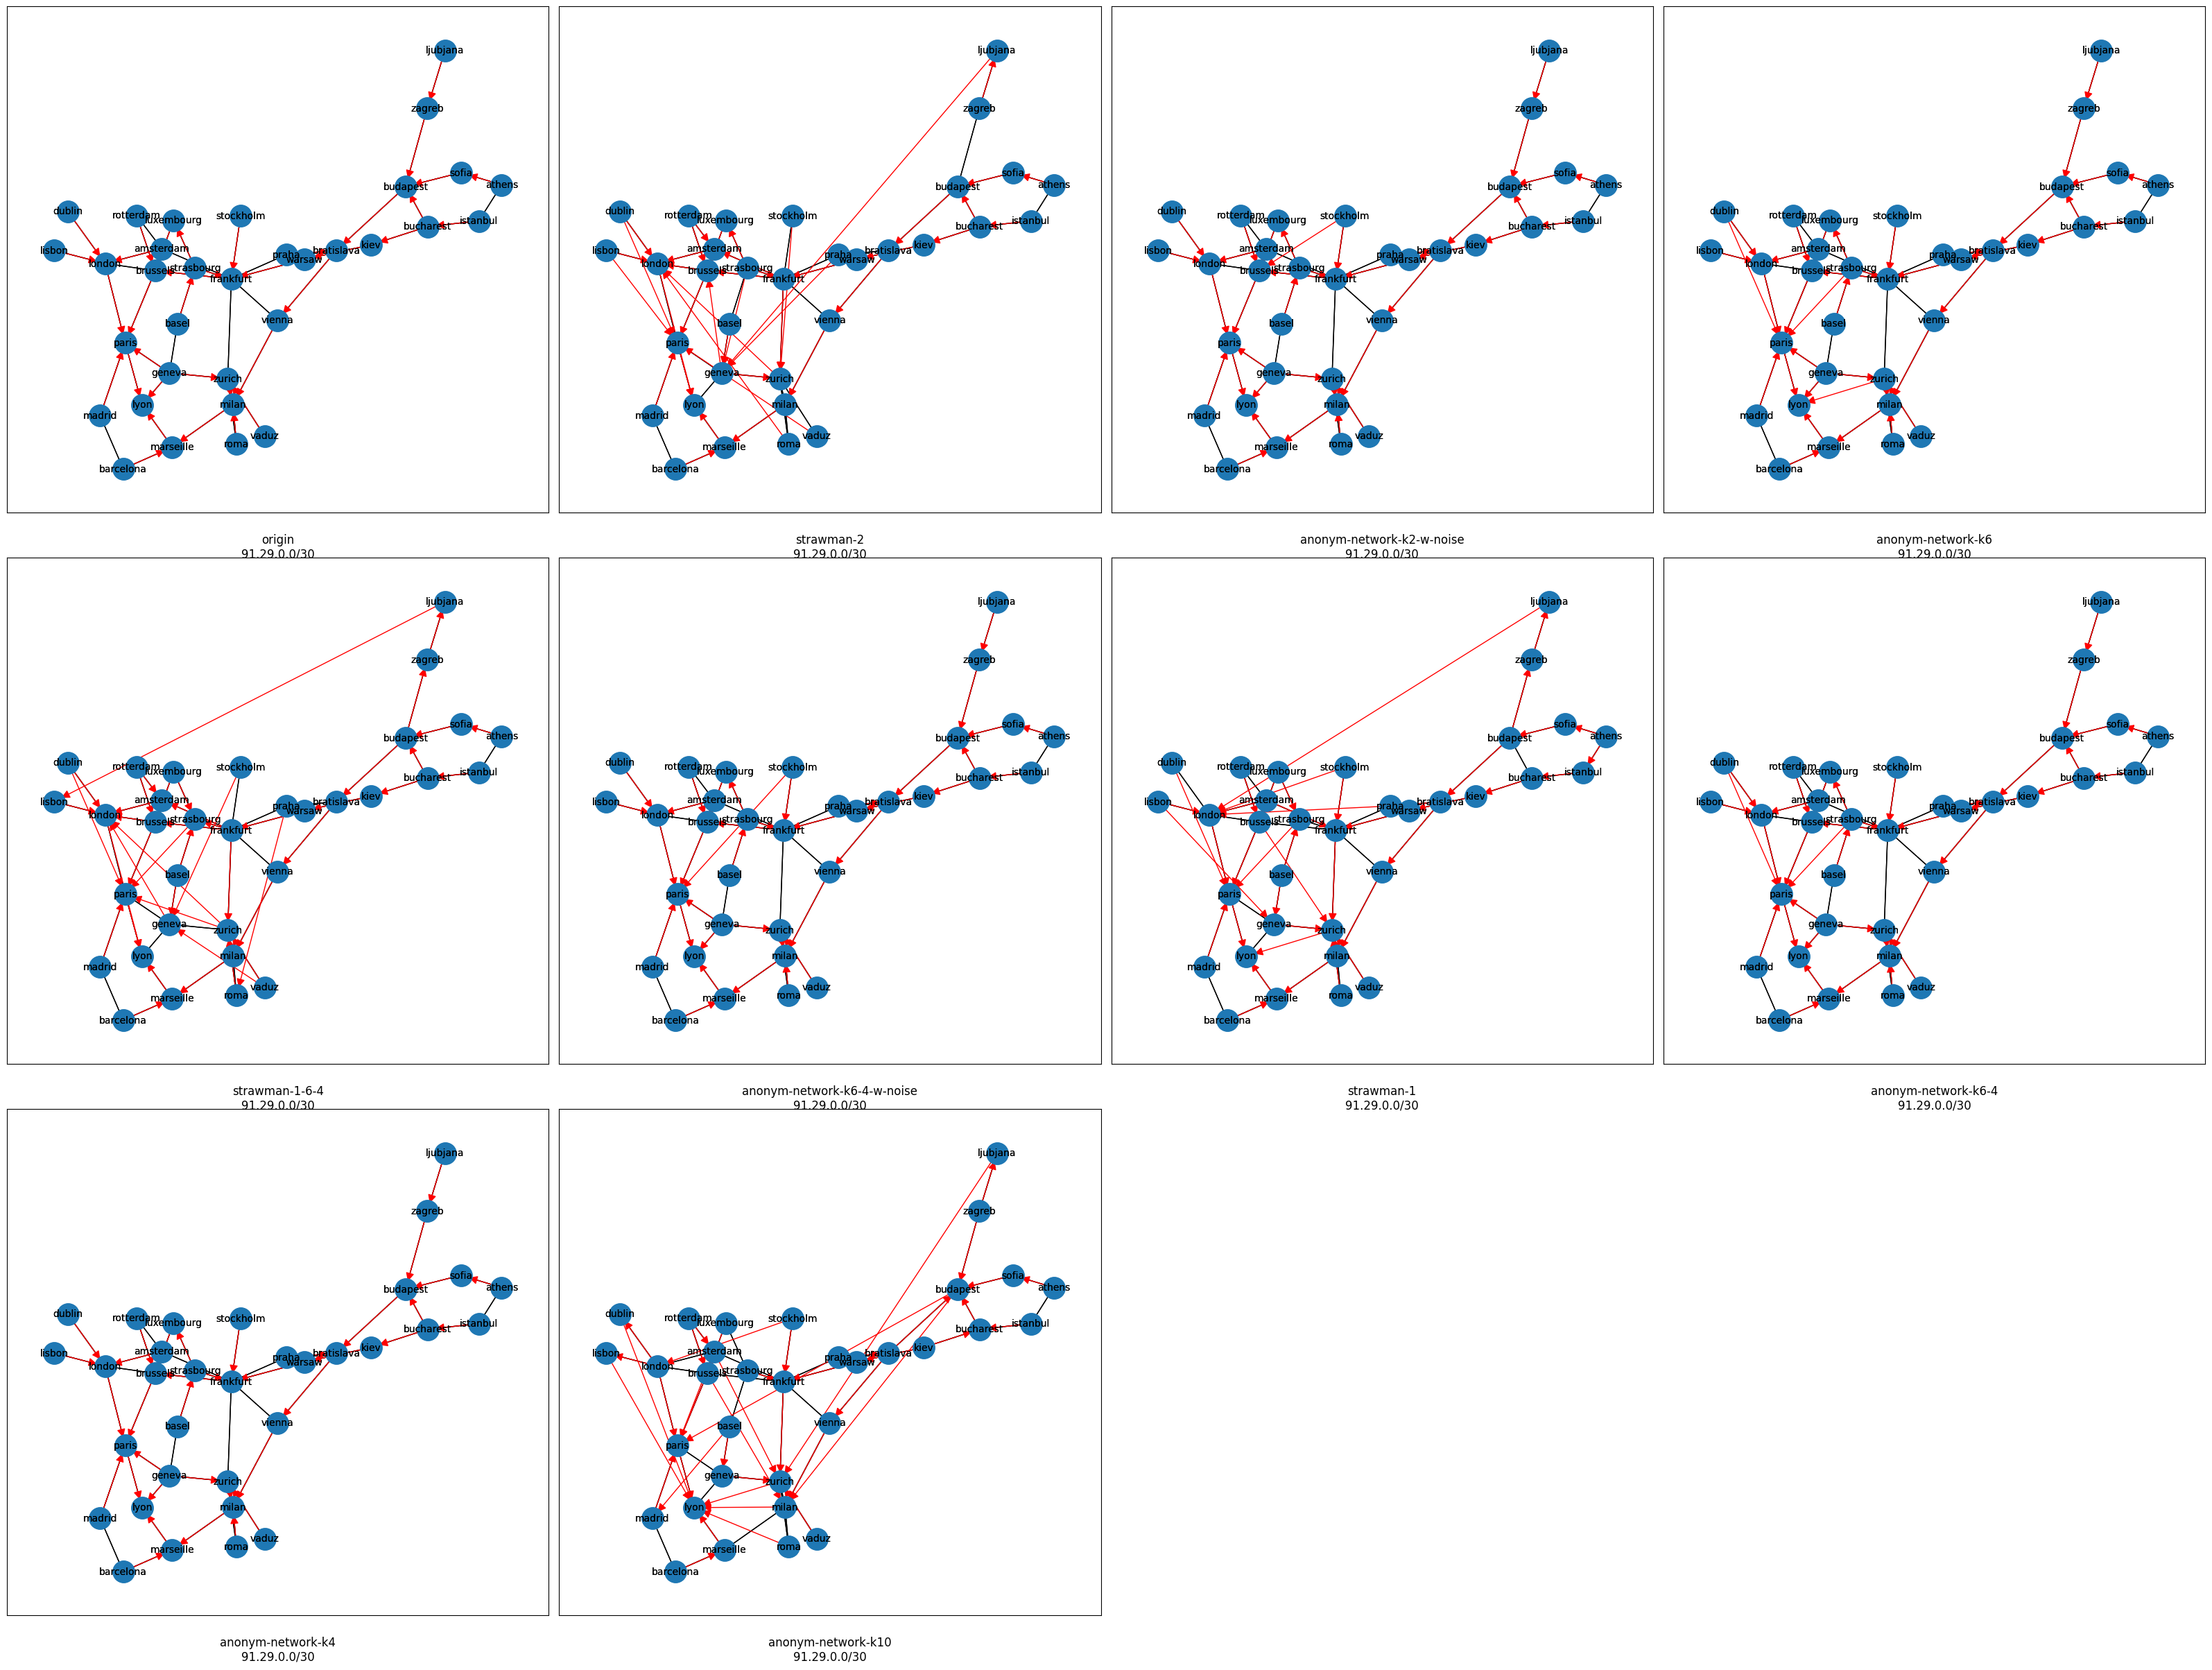

In [5]:
NETWORK_PATH_BASE = "/home/yongting/research/configs/config2spec-confmask/scenarios/confmask/bics-ospf"
# networks_to_look = ["origin", "anonym-network-k6-2-w-noise-n", "anonym-network-k10-2-w-noise-n"]
networks_to_look = list(set([os.path.basename(directory) for directory in glob.glob(f"{NETWORK_PATH_BASE}/*")]) - set(["origin"]))
networks_to_look.insert(0, "origin")
read_and_plot_forwarding_graphs_of_a_prefix(NETWORK_PATH_BASE, networks_to_look, "91.29.0.0/30")